# The Analaysis of Spectra of Noble Gases

### By Emir Muhammad and Edward Penny 

## 1. Initializing the Notebook



### Importing Modules
The notebook requires various modules and tools from outside sources. Most of these has been encountered before, such as numpy, scipy, and matplotlib, however others are new such as astropy and jupyter widgets. The code below imports all necessary modules for the notebook to work.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.optimize import curve_fit

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

### Importing all the necessary strings for importing the data
The code below works only for Emir and Edward on their machines, where they have placed the experimental data as well as the database in specified locations. This bit of code allows the authors to collaborate by switching between different locations quickly. 

The code itself is written such that the functions themselves do not depend on any specific location, so it should work on any machine so long as the user properly defines the paths of the files and databases. However, please write down 'user' in the name_of_owner field for it to pass through.

In [2]:
name_of_owner = 'Edward'

if name_of_owner == 'Emir':
    Xenonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Xenon Data/' 
    Kryptonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Krypton Data/' 
    Argonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Argon Data/'
    Neonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Neon Data/'
    Heliumlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Helium 500/'
    Cadmiumlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Cadmium Calibration Data/'
    LampNeonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Neon discharge lamp data/'
    LampXenonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Extra Xenon data/'

    heliumtext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/helium.txt'
    neontext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/fakeneon.txt'   
    argontext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/fakeargon.txt' 
    kryptontext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/krypton.txt'
    xenontext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/xenon.txt'
    
elif name_of_owner == 'Edward': 
    Xenonlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Xenon data/'  
    Kryptonlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Krypton data/'  
    Argonlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Argon Data/'
    Neonlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Neon Data/'
    Heliumlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Helium Data/'
    Cadmiumlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Cadmium Calibration Data/'

    heliumtext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/helium.txt'
    neontext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/neon.txt'
    argontext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/argon.txt'
    kryptontext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/krypton.txt'
    xenontext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/xenon.txt'

elif name_of_owner == 'user':
    pass

else:
    print('please add in the correct name, else the entire code will not run properly.')
    print(0/0)

This code is too important for me to allow you to jeopardize it


## 2. Defining functions to import FITS files and plotting

This section corresponds to the early work that was done, where figuring out how to import the data from the spectroscope was the goal. Each function has a different purporse as seen in their docstrings.

In [3]:
def mean_data(location):
    '''Returns the average 'FITS image' from a folder of FITS files. 
  
    Requires all the data to be kept in a single folder. 
  
    Parameters: 
    location(str): Path to folder containing FITS data.
  
    Returns: 
    2d numpy array representing the average.
    '''
    tracks = []
    for i in os.listdir(location):
        if i.endswith(".fit"):
            filename =location + '/' + str(i)
            image_file = get_pkg_data_filename(filename)
            image_data = fits.getdata(image_file, ext=0) #uses astropy module to convert the fit file into an array
            tracks.append(image_data)
    mean = np.mean(tracks, axis = 0)
    return mean

In [4]:
def plot_datapx(data, a=240, b=360):
    ''' Plots a 2d-array as intensity vs pixel. 
  
    Parameters: 
    data(2d-array): The data that is plotted. Represents a single FITS file
    a(int): lower bound for horizontal slicing
    b(int): upper bound for horizontal splicing
    
    Returns: 
    plot1: Plot of Intensity vs Pixel Number
    plot2: Visualization of FITS file
    '''
    data = data
    snipmean = data[a:b]   
    numberofx = snipmean.shape[1]
    x = np.linspace(1, numberofx, numberofx)
    y = np.mean(snipmean, axis = 0)
    plt.title('Plot of superMean Intensity Vs Pixel Number')
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Intensity(arbitrary units)')
    plt.plot(x, y)
    plt.show()
    plt.figure()
    plt.imshow(data, cmap='gray')
    plt.colorbar()

In [5]:
def plot_datawv(data, a=240, b=360, MINspacebetweenpeaks = 10, PROMCUTOFF = 250, Element = None):
    ''' Plots a 2d-array as intensity vs wavelength along with found peaks. 
  
    Conversion of pixel number to wavelength is done in labs using a Cadmium Calibration Lamp. 
    Wavelength calibration is hardcoded into this function in the variables A and B. 
  
  
    Parameters: 
    data(2d-array): The data to be plotted. Represents a single FITS file
    a(str): Lower bound for horizontal splicing
    b(str): Upper bound for horizontal splicing
    MINspacebetweenpeaks
    PROMCUTOFF
    Element(str) = Optional variable for labling the figure
    
    Returns: 
    1 Plot of the Intensity vs Wavelength of data, along with vertical lines representing peaks found by the code.
    '''
    data = data
    snipmean = data[a:b]
    numberofx = snipmean.shape[1]
    xt = np.linspace(1, numberofx, numberofx)
    A = 6.640*10**(-10) #wavelength calibration
    B = 2.736*10**(-7)  #wavelength calibration
    x = A*xt + B        #wavelength calibration
    y = np.mean(snipmean, axis = 0)
    
    if Element == None:  #title plotting
        plt.title(f'Plot of Mean Intensity Vs Wavelength')
    else:
        plt.title(f'Plot of Mean Intensity Vs Wavelength {Element}')
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Intensity(arbitrary units)')
    
    peaks,_ = find_peaks(y, distance = MINspacebetweenpeaks)
    proms = peak_prominences(y, peaks)[0]
    proms[proms < PROMCUTOFF] = 0 # making an array of 1's and 0's 
    promsford = list(proms)
    L0 = promsford.count(0)
    DC = 0
    while DC<L0:
        DC +=1
        promsford.remove(0) # finding prominences for the dictionary
    proms[proms > PROMCUTOFF] = 1 # making an array of 1's and 0's
    proms[proms == PROMCUTOFF] = 1 
    keypeaks = proms*peaks # setting all peaks with low prominences to 0
    Lkeypeaks = list(keypeaks) # have to make it into a list to use count and remove
    L1= Lkeypeaks.count(0) # finding the number of 0's for the loop
    RC= 0 
    while RC<L1:
        RC +=1
        Lkeypeaks.remove(0) # remove only removes the first 0 so have to loop it through
    keypeaks = np.array(Lkeypeaks) # convert back to an array for the graphing
    Wavelengthsford= A*keypeaks + B
    Wavelengthsford = list(Wavelengthsford) #getting wavelengths of peaks for the dictionary
    for n in np.nditer(keypeaks):
        plt.axvline(x= A*n+ B,linestyle=':', color = 'r', label='f0')
    plt.plot(x, y)
    Peaksdict = {}
    for i in range(len(promsford)): #assembling the peak dictionary
        Peaksdict[Wavelengthsford[i]] = promsford[i]
    plt.show()
    return None

In [6]:
def peaks_datawv(data, a=240, b=360, MINspacebetweenpeaks = 10, PROMCUTOFF = 250):
    '''Returns a dictionary of Peaks and Intensity for each found peak. 
  
    Conversion of pixel number to wavelength is done in labs using a Cadmium Calibration Lamp. 
    Wavelength calibration is hardcoded into this function in the variables A and B. 
    
  
    Parameters: 
    data(2d-array): The data to be plotted. Represents a single FITS file
    a(str): Lower bound for horizontal splicing
    b(str): Upper bound for horizontal splicing
    MINspacebetweenpeaks
    PROMCUTOFF
    
    Returns: 
    Dictionary = {Wavelength of peak: Intensity}
    '''
    data = data
    snipmean = data[a:b]
    numberofx = snipmean.shape[1]
    xt = np.linspace(1, numberofx, numberofx)
    A = 6.640*10**(-10) #calibration from pixels to wavelengths
    B = 2.736*10**(-7)
    x = A*xt + B
    y = np.mean(snipmean, axis = 0)
    peaks,_ = find_peaks(y, distance = MINspacebetweenpeaks)
    proms = peak_prominences(y, peaks)[0]
    proms[proms < PROMCUTOFF] = 0 # making an array of 1's and 0's 
    promsford = list(proms)
    L0 = promsford.count(0)
    DC = 0
    while DC<L0:
        DC +=1
        promsford.remove(0) # finding prominences for the dictionary
    proms[proms > PROMCUTOFF] = 1 # making an array of 1's and 0's 
    keypeaks = proms*peaks # setting all peaks with low prominences to 0
    Lkeypeaks = list(keypeaks) # have to make it into a list to use count and remove
    L1= Lkeypeaks.count(0) # finding the number of 0's for the loop
    RC= 0 
    while RC<L1:
        RC +=1
        Lkeypeaks.remove(0) # remove only removes the first 0 so have to loop it through
    keypeaks = np.array(Lkeypeaks) # convert back to an array for the graphing
    Wavelengthsford= A*keypeaks + B
    Wavelengthsford = list(Wavelengthsford) #getting wavelengths of peaks for the dictionary
    Peaksdict = {}
    for i in range(len(promsford)): #assembling the peak dictionary
        Peaksdict[Wavelengthsford[i]] = promsford[i]
    return Peaksdict

In [7]:
def extrainfo(data, a=240, b=360, MINspacebetweenpeaks = 10, PROMCUTOFF = 250):
    '''Returns a list of tuples used for Peak Matching and Gaussian conversion
  
    Conversion of pixel number to wavelength is done in labs using a Cadmium Calibration Lamp. 
    Wavelength calibration is hardcoded into this function in the variables A and B. 
    
    
    Parameters: 
    data(2d-array): The data to be plotted. Represents a single FITS file
    a(str): Lower bound for horizontal splicing
    b(str): Upper bound for horizontal splicing
    MINspacebetweenpeaks
    PROMCUTOFF
    
    Returns: 
    List of Tuples: each tuple of the format (wavelength, width, intensity) for each peak
    '''
    data = data
    snipmean = data[a:b]
    numberofx = snipmean.shape[1]
    xt = np.linspace(1, numberofx, numberofx)
    A = 6.662*10**(-10)
    B = 2.730*10**(-7)
    x = A*xt + B
    y = np.mean(snipmean, axis = 0)
    peaks,_ = find_peaks(y, distance = MINspacebetweenpeaks)
    proms = peak_prominences(y, peaks)[0]
    proms[proms < PROMCUTOFF] = 0 # making an array of 1's and 0's 
    promsford = list(proms)
    L0 = promsford.count(0)
    DC = 0
    while DC<L0:
        DC +=1
        promsford.remove(0) # finding prominences for the dictionary
    proms[proms > PROMCUTOFF] = 1 # making an array of 1's and 0's 
    keypeaks = proms*peaks # setting all peaks with low prominences to 0
    Lkeypeaks = list(keypeaks) # have to make it into a list to use count and remove
    L1= Lkeypeaks.count(0) # finding the number of 0's for the loop
    RC= 0 
    while RC<L1:
        RC +=1
        Lkeypeaks.remove(0) # remove only removes the first 0 so have to loop it through
    keypeaks = np.array(Lkeypeaks) # convert back to an array for the graphing
    Wavelengthsford= A*keypeaks + B
    Wavelengthsford = list(Wavelengthsford) #getting wavelengths of peaks for the dictionary
    Peaksdict = {}
    for i in range(len(promsford)): #assembling the peak dictionary
        Peaksdict[Wavelengthsford[i]] = promsford[i]

        
    '''finding rel intensities'''
    keypeaks =keypeaks.astype(int)
    peaksy = []
    for n in keypeaks:
        peaksy.append(y[n])
    TT=np.max(peaksy)
    relint=(peaksy) #replace 1 with 1000/TT
    Relintdict = {}
    for i in range(len(peaksy)):
        Relintdict[Wavelengthsford[i]] = relint[i]
    widths = peak_widths(y, keypeaks)
    Wavelengthsford=np.array(Wavelengthsford)
    widths=widths[0]
    GD=[]
    for a,b,c in zip(Wavelengthsford,relint,widths):
        temp=(a, c*A, b)
        GD.append(temp)
    return(GD)

## 3. Importing Databases into the Notebook as Dictionaries

The code below is for importing the dictionaries found at http://astro.u-strasbg.fr/~koppen/discharge/ to be used in the analysis.

In [8]:
def importdict(textlocation):
    '''Returns a dictionary of {wavelength:Relativeintensity} from the text file representing the Database'''
    f=open(textlocation,"r")
    lines=f.readlines()
    result=[]
    results2 = []
    for x in lines:
        result.append(x.split(' ')[0])
        results2.append(x.split(' ')[-1])
    f.close()
    a = [float(i) for i in results2]
    #in this bit put the code to ma
    temp = {}
    results = [float(i)*10**(-10) for i in result]
    for i in range(len(result)): #assembling the peak dictionary
        temp[results[i]] = a[i]
    return temp

Heliumdict = importdict(heliumtext)
Neondict = importdict(neontext)
Argondict = importdict(argontext)
Kryptondict = importdict(kryptontext)
Xenondict = importdict(xenontext)



In [9]:
'''Master Dictionary'''
True_element_rel_in_d = {'He': Heliumdict, 'Ne' : Neondict, 'Ar' : Argondict, 'Kr':  Kryptondict, 'Xe' : Xenondict}

'''Creating a general dictionary of {elements:[wavelengths]}'''
datad= {}
for keys in True_element_rel_in_d.keys():
    datad.update({f'{keys}': list(True_element_rel_in_d.get(f'{keys}').keys())})

## 4. Wavelength matching function

The code here is used to match the peaks found in section 2 with the database from section 3 as a sanity check, as well as showing that the analysis is headed in the right direction

In [10]:
def matchelements(location): 
    '''Returns a dictionary containing the matched peaks for each element from the captured spectrum and datad

    Parameters: 
    locatoin(str): Path to folder where all data is kept
    
    Returns: 
    Dictionary: {element: [wavelengths of matches]}
    '''
    testunknown= peaks_datawv(mean_data(location))
    unknown = list(testunknown.keys())
    founddict = {}
    for element in datad.keys():
        thelist = []
        for x in unknown:
            for y in datad.get(element):
                if abs(x - y) < 2*6.640*10**(-10):  #GET RID OF THE TIMES 2 MULTIPLE
                    thelist.append(round(y, 11))
        founddict.update({f'{element}' : thelist})
    return founddict

## 5. Gaussian Conversion


To perform a proper curve fitting analysis, the dictionary and the spectrum must be converted into Gaussian functions for the curve fitting code to use.

In [12]:
def gaussian(x, mu, sig, a, cfudge = 0):
    '''Function to generate a Gaussian Curve'''
    return a*np.exp(-np.power(x - mu - (cfudge), 2.) / (2 * np.power(sig, 2.)))

def fullgaussian(x, y, cfudge = 0):
    '''Function containing a series of Gaussian Curves summed up.
    
    Parameters: 
    x(1d-array): An array of wavelengths for the Gaussian to plot
    y(list of tuples): where each tuple is of the format (mu, sig, a)

    Returns: 
    The value of the gaussian at x.
    '''
    b = 0
    for mu, sig, a in y:
        b += gaussian(x, mu, sig, a, cfudge)
    return b
    
def plotgaussiandict(useddict, Element = None):
    '''Plots a database dictionary into a Gaussian curve'''
    emptylist = []
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    useddict = useddict
    for x in useddict:
        temp = (x, 1e-09, useddict[x]*100)
        emptylist.append(temp)
    plt.plot(x_values, fullgaussian(x_values, emptylist))
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Arbitrary Intensity')
    if Element == None:
        plt.title(f'Gaussian-Converted Plot of Dictionary')
    else:
        plt.title(f'Gaussian-Converted Plot of Dictionary {Element}')
    plt.show()
    
def plotgaussianspectrum(location, Element = None):
    '''Plots a captured spectrum into a Gaussian curve'''
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    y = extrainfo(mean_data(location))
    plt.plot(x_values, fullgaussian(x_values, y))
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Arbitrary Intensity')
    if Element == None:
        plt.title(f'Gaussian-Converted Plot of Captured Spectrum')
    else:
        plt.title(f'Gaussian-Converted Plot of Captured {Element} Spectrum')
    plt.show()

### Analysis of what each Peak Corresponds to

The code below provides a more thorough analysis of what each peak corresponds to in the spectrums

In [13]:
def plotgaussianmatchedspect(location, Element = None):
    '''Plots the Gaussian spectrum overlayed with vertical lines showing what each peak corresponds to.'''
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    y = extrainfo(mean_data(location))
    plt.plot(x_values, fullgaussian(x_values, y))
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Arbitrary Intensity')
    testloc = matchelements(location)
    for a in testloc.keys():
        if a == 'He':
            color = 'b'
        elif a == 'Ne':
            color = 'g'
        elif a == 'Ar':
            color = 'r'
        elif a == 'Kr':
            color = 'c'
        elif a == 'Xe':
            color = 'm'
        plt.axvline(testloc[a][0], linestyle=':', color = color, label = a) #duplicate line for labeling purposes
        for x in testloc[a]:
            plt.axvline(x,linestyle=':', color = color)            
    if Element == None:
        plt.title(f'Plot of Matched Gaussian Lines')
    else:
        plt.title(f'Plot of Matched Gaussian Lines {Element}')
    plt.legend()
    plt.show()

In [14]:
def plotgaussiandicttemp(useddict, x_values, multiple):
    emptylist = []
    useddict = useddict
    for x in useddict:
        temp = (x, 1e-09, useddict[x]*multiple)
        emptylist.append(temp)
    plt.plot(x_values, fullgaussian(x_values, emptylist), label = 'database', alpha = 0.5, marker = ',')


def tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 50):
    #testloc = matchelements(location)
    plt.axvline(testloc[a][0], linestyle=':', color = color, label = a)
    for x in testloc[a]:
        plt.axvline(x,linestyle=':', color = color)
    if Element == None:
        plt.title(f'Plot of Matched Gaussian Lines')
    else:
        plt.title(f'Plot of Matched Gaussian Lines {Element}')
    plt.plot(x_values, fullgaussian(x_values, y))
    plotgaussiandicttemp(True_element_rel_in_d[a], x_values, multiple)    
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Arbitrary Intensity')
    plt.legend()
    plt.show()

def plotgaussiananalysis(location, Element = None):
    '''Returns different plots where the captured spectrum is overlayed with the dictionary and lines showing any matched peaks.
    
    Parameters: 
    location(str): Path to where the folder containing data is kept

    Returns: 
    Plots of overlayed Spectrum, Dictionaries, and Matches.
    '''
    location = location
    testloc = matchelements(location)
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    y = extrainfo(mean_data(location))

    for a in testloc.keys():
        if a == 'He':
            color = 'b'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 15)
        elif a == 'Ne':
            color = 'g'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 50)
        elif a == 'Ar':
            color = 'r'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 7.5)
        elif a == 'Kr':
            color = 'c'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 5)
        elif a == 'Xe':
            color = 'm'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 10)
def singleanalysis(location, a, multiple, Element = None):
    '''Returns a single plot where the captured spectrum is overlayed with the respective dictionary and lines showing any matched peaks.
    
    Parameters: 
    location(str): Path to where the folder containing data is kept
    a(str): The key of the element for dictionary, format of 'He'

    Returns: 
    Plot of overlayed Spectrum, Dictionaries, and Matches.
    '''
    location = location
    testloc = matchelements(location)
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    y = extrainfo(mean_data(location))
    useddict = True_element_rel_in_d[a]
    color = 'k'
    plt.plot(x_values, fullgaussian(x_values,y), label = 'captured')
    plotgaussiandicttemp(useddict, x_values, multiple)
    plt.legend()
    plt.show()

## 6. Scaling Dictionaries

The Dictionaries from online are simply showing relative intensities. These intensities need
to be scaled according to transmission probabilities.

In [15]:
def scaleme(dictionary, I, wvint):
    '''Scales a dictionary with the proper intensity at a specified wavelength'''
    temp = {}
    scale = I/wvint #inputscaleing here
    for wavelength in dictionary:
        temp.update({wavelength : dictionary[wavelength]*scale})
    return temp
HeComparableTrueDict = scaleme(Heliumdict, 5.7234*10**(-12), 50)
NeComparableTrueDict = scaleme(Neondict, 2.278*10**(-11), 500 )
ArComparableTrueDict = scaleme(Argondict, 1.856*10**(-12), 200)
KrComparableTrueDict = scaleme(Kryptondict, 7.49*10**(-13), 2000)
XeComparableTrueDict = scaleme(Xenondict, 1.773*10**(-12), 500)

## 7. Curve Fitting

Once the dictionaries have been properly scaled and the Gaussian Spectrums have been defined, curve fitting can be applied.

In [18]:
def _generalizedgaussian(useddict):
    useddict = useddict
    emptylist = []
    for x in useddict:
        temp = (x, 1e-09, useddict[x]*10**(10))
        emptylist.append(temp)
    return emptylist
def generalizedgaussian(x, a, b, c, d, e, cfudge):
    '''Returns the function of a generalized gaussian containing all 5 elements from the database'''
    HeList = _generalizedgaussian(HeComparableTrueDict)
    NeList = _generalizedgaussian(NeComparableTrueDict)
    ArList = _generalizedgaussian(ArComparableTrueDict)
    KrList = _generalizedgaussian(KrComparableTrueDict)
    XeList = _generalizedgaussian(XeComparableTrueDict)
    
    function = 0 
    function += a*fullgaussian(x, HeList, cfudge)
    function += b*fullgaussian(x, NeList, cfudge)
    function += c*fullgaussian(x, ArList, cfudge)
    function += d*fullgaussian(x, KrList, cfudge)
    function += e*fullgaussian(x, XeList, cfudge)
    return function

### Curve Fitting for Helium Ampule Example

[8.76085120e+02 8.90120095e-01 1.02922201e+02 1.02871331e+04
 1.65941869e+04 4.05518079e-09]

[4.80012168e+02 5.99166628e+02 2.74868603e+02 1.91020963e+01
 1.36007229e+03 4.83175950e-10]


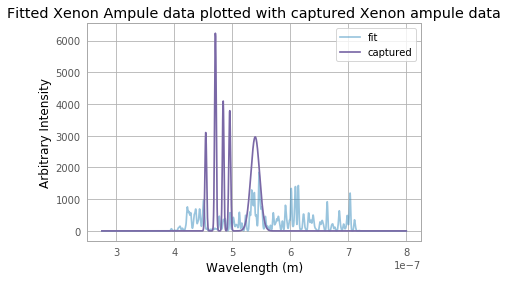

In [22]:
'''This code plots the fitted curve on the same graph as the our measured data in gaussian form this is useful for comparison'''
location= Xenonlocation

x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
xdata = x_values


y = extrainfo(mean_data(location))
ydata = fullgaussian(x_values, y)

func = generalizedgaussian
p0 = (0, 0, 0, 0, 1000, 0)
popt, pcov = curve_fit(func, xdata, ydata, p0 = p0, bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf, 1*10**-8]))
print(popt)
print('')
print(np.sqrt(np.diag(pcov)))


plt.plot(x_values, generalizedgaussian(x_values, a=popt[0], b=popt[1], c=popt[2], d=popt[3], e=popt[4], cfudge = popt[5]), label = 'fit',   alpha = 0.5)
plt.plot(xdata, ydata, label = 'captured')
plt.title('Fitted Xenon Ampule data plotted with captured Xenon ampule data')
plt.xlabel(r'Wavelength (m)')
plt.ylabel(r'Arbitrary Intensity')
plt.legend()
plt.show()

In [19]:
x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
xdata = x_values
func = generalizedgaussian
def pcomposition(location, p0 = None, thing = None):
    '''Returns the Percentage Composition of an ampule
    Also returnsa pie chart containing the data
    '''
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    location = location
    y = extrainfo(mean_data(location))
    ydata = fullgaussian(x_values, y)
    popt, pcov = curve_fit(func, xdata, ydata, p0 = p0, bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf, 1*10**-8]))
    A = np.sum(popt) - popt[5]
    Npopt=popt*1/A
    error=np.sqrt(np.diag(pcov))
    Nerror=error*1/A
    print(popt)
    print('')
    print(error)
    print('')
    print('')
    
    print(f'Percentage composition of {thing}')
    print('')
    print(f'Helium:{Npopt[0]} ± {Nerror[0]}')
    print(f'Neon:{Npopt[1]} ± {Nerror[1]}')
    print(f'Argon:{Npopt[2]} ± {Nerror[2]}')
    print(f'Krypton:{Npopt[3]} ± {Nerror[3]}')
    print(f'Xenon:{Npopt[4]} ± {Nerror[4]}')
    print('')
    print(f'Wavelength shift:{popt[5]} ± {error[5]}')
    print('')
    labels = ['Helium', 'Neon', 'Argon','Krypton', 'Xenon']
    sizes = [Npopt[0],Npopt[1], Npopt[2], Npopt[3], Npopt[4]]
    explode = (0.1, 0.1, 0.1, 0.1, 0.1)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90,colors = ['orange','blue','purple','green','red']) #plots the pie chart
    ax1.axis('equal')
    plt.title(f'Percentage composition of the {thing}')
    plt.show()
    print('')

[1.05076013e+04 8.96044832e+03 3.10629702e+03 8.99949364e+02
 6.01792932e+03 4.01520993e-13]

[1.75120544e+03 1.66796441e+03 8.73087164e+02 3.17915291e+01
 3.81476099e+02 9.18279729e-10]


Percentage composition of Helium Ampule

Helium:0.3562837734025019 ± 0.05937854520082756
Neon:0.30382408282548645 ± 0.056556071701140624
Argon:0.10532596247559965 ± 0.029603977103585668
Krypton:0.030514800186656536 ± 0.0010779630473717443
Xenon:0.2040513811097552 ± 0.01293480210959713

Wavelength shift:4.0152099339133265e-13 ± 9.182797286717767e-10



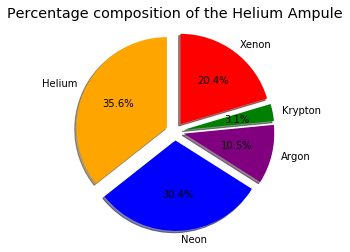


[3.29742778e+03 1.35803272e+04 2.64208904e+03 4.11355752e+02
 6.76316831e+03 4.06141492e-13]

[2.79912080e+03 3.38120065e+03 1.61530986e+03 6.28290125e+01
 9.34409017e+02 1.93248092e-09]


Percentage composition of Neon Ampule

Helium:0.12352522315214874 ± 0.10485810299376837
Neon:0.5087337965484886 ± 0.12666344585019532
Argon:0.09897552280265752 ± 0.060511260545395934
Krypton:0.015409832908723782 ± 0.002353642994437724
Xenon:0.2533556245879815 ± 0.03500397586362011

Wavelength shift:4.0614149249358846e-13 ± 1.9324809243937765e-09



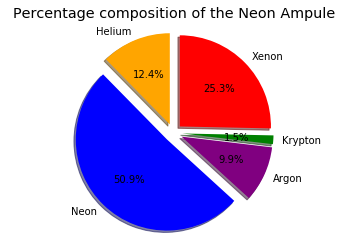


[2.11641082e+03 4.78590315e+03 3.43245901e+03 7.12463494e+02
 4.72002645e+03 6.63955790e-09]

[1.36162895e+03 1.48059209e+03 8.70686420e+02 2.82444575e+01
 3.65629041e+02 1.01208400e-09]


Percentage composition of Argon Ampule

Helium:0.13422816812790414 ± 0.0863579781923192
Neon:0.303534175495951 ± 0.09390292415863018
Argon:0.2176952988375884 ± 0.05522115181905687
Krypton:0.04518625064122965 ± 0.0017913354779770013
Xenon:0.29935610689732683 ± 0.023189125649728647

Wavelength shift:6.639557898816414e-09 ± 1.012083995313988e-09



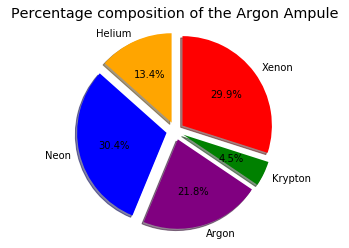


[9.60214910e+03 1.49291132e+04 2.32387049e+03 1.03563936e+04
 4.67110682e+04 3.93529446e-09]

[1.38294281e+02 4.35701633e+01 8.90839968e+02 3.40136472e+00
 1.43720442e+01 3.33024550e-10]


Percentage composition of Krypton Ampule

Helium:0.11441673309237896 ± 0.0016478789919410469
Neon:0.17789146388302465 ± 0.0005191708327455166
Argon:0.027690641582952702 ± 0.010615019382343894
Krypton:0.12340411626483279 ± 4.0529785071774684e-05
Xenon:0.556597045176811 ± 0.00017125357348223474

Wavelength shift:3.935294457173141e-09 ± 3.330245504620563e-10



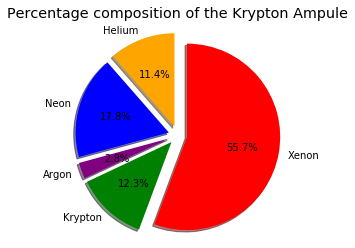


[8.76085120e+02 8.90120095e-01 1.02922201e+02 1.02871331e+04
 1.65941869e+04 4.05518079e-09]

[4.80012168e+02 5.99166628e+02 2.74868603e+02 1.91020963e+01
 1.36007229e+03 4.83175950e-10]


Percentage composition of Xenon Ampule

Helium:0.03144461015017171 ± 0.017228686065321405
Neon:3.194835607580779e-05 ± 0.02150540010846247
Argon:0.0036941027770408625 ± 0.009865635031432465
Krypton:0.3692276963048443 ± 0.0006856159949293587
Xenon:0.5956016424118673 ± 0.04881596782301353

Wavelength shift:4.055180792546534e-09 ± 4.831759498081682e-10



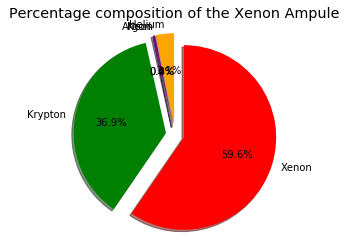

In [20]:
'''when run returns the percentage composition of all the ampules with errors and pie charts containing the data'''
p0 = (1000, 0, 0, 0, 0, 0)
pcomposition(Heliumlocation, p0, thing = 'Helium Ampule' )
p0 = (0, 1000, 0, 0, 0, 0)
pcomposition(Neonlocation, p0, thing = 'Neon Ampule' )
p0 = (0, 0, 1000, 0, 0, 0)
pcomposition(Argonlocation, p0, thing = 'Argon Ampule' )
p0 = (0, 0, 0, 1000, 0, 0)
pcomposition(Kryptonlocation, p0, thing = 'Krypton Ampule' )
p0 = (0, 0, 0, 0, 1000,0)
pcomposition(Xenonlocation, p0, thing = 'Xenon Ampule' )